In [96]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import konlpy
import gensim
from konlpy.tag import Mecab
from collections import Counter

In [97]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.tail() 
test_data.head() # first id : 6270596
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [123]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

vocab = []
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) 
        temp_X = [word for word in temp_X if not word in stopwords] 
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) 
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index, vocab
    
X_train, y_train, X_test, y_test, word_to_index, vocab = load_data(train_data, test_data) 

In [124]:
total_data_text = X_train + X_test
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)

In [125]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, 
                                                        value=word_to_index["<PAD>"], 
                                                        padding="pre", 
                                                        maxlen=maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, 
                                                        value=word_to_index["<PAD>"], 
                                                        padding="pre", 
                                                        maxlen=maxlen)

In [126]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=43)

In [127]:
voca_size = 10000
word_vector_dim = 100

Epoch 1/5
229/229 [==============================] - 9s 22ms/step - loss: 0.4782 - accuracy: 0.7704 - val_loss: 0.3709 - val_accuracy: 0.8399
Epoch 2/5
229/229 [==============================] - 4s 17ms/step - loss: 0.3285 - accuracy: 0.8625 - val_loss: 0.3451 - val_accuracy: 0.8520
Epoch 3/5
229/229 [==============================] - 4s 17ms/step - loss: 0.2879 - accuracy: 0.8823 - val_loss: 0.3345 - val_accuracy: 0.8574
Epoch 4/5
229/229 [==============================] - 4s 18ms/step - loss: 0.2544 - accuracy: 0.8985 - val_loss: 0.3438 - val_accuracy: 0.8581
Epoch 5/5
229/229 [==============================] - 4s 18ms/step - loss: 0.2243 - accuracy: 0.9120 - val_loss: 0.3462 - val_accuracy: 0.8555


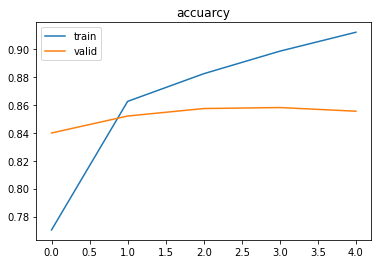

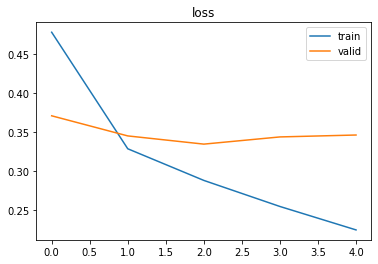

1537/1537 [==============================] - 8s 5ms/step - loss: 0.3483 - accuracy: 0.8545
[0.3483172655105591, 0.8545069694519043]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [128]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(voca_size, word_vector_dim))
model.add(tf.keras.layers.LSTM(100, return_sequences=True))
model.add(tf.keras.layers.LSTM(50, return_sequences=True))
model.add(tf.keras.layers.LSTM(25, return_sequences=True))
model.add(tf.keras.layers.LSTM(10))
model.add(tf.keras.layers.Dense(5, activation="relu"))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, batch_size=512, validation_data=(X_valid, y_valid))

accuarcy = history.history["accuracy"]
loss = history.history["loss"]
valid_acc = history.history["val_accuracy"]
valid_loss = history.history["val_loss"]

plt.plot(accuarcy, label="train")
plt.plot(valid_acc, label="valid")
plt.title("accuarcy")
plt.legend()
plt.show()

plt.plot(loss, label="train")
plt.plot(valid_loss, label="valid")
plt.title("loss")
plt.legend()
plt.show()

print(model.evaluate(X_test, y_test))
print(type(X_train))
print(type(X_train[0]))

Epoch 1/5
229/229 [==============================] - 2s 6ms/step - loss: 0.5608 - accuracy: 0.7487 - val_loss: 0.4883 - val_accuracy: 0.8374
Epoch 2/5
229/229 [==============================] - 1s 5ms/step - loss: 0.4406 - accuracy: 0.8613 - val_loss: 0.4543 - val_accuracy: 0.8447
Epoch 3/5
229/229 [==============================] - 1s 5ms/step - loss: 0.3739 - accuracy: 0.8896 - val_loss: 0.4384 - val_accuracy: 0.8495
Epoch 4/5
229/229 [==============================] - 1s 5ms/step - loss: 0.3097 - accuracy: 0.9165 - val_loss: 0.4465 - val_accuracy: 0.8475
Epoch 5/5
229/229 [==============================] - 1s 5ms/step - loss: 0.2559 - accuracy: 0.9362 - val_loss: 0.4835 - val_accuracy: 0.8469


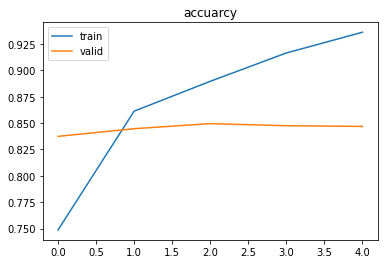

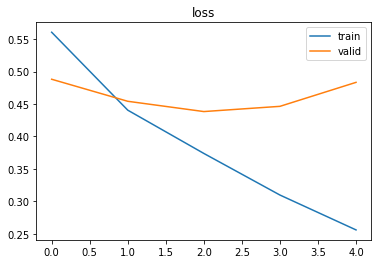

1537/1537 [==============================] - 3s 2ms/step - loss: 0.4868 - accuracy: 0.8463
[0.4868091344833374, 0.8462680578231812]


In [129]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(voca_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, batch_size=512, validation_data=(X_valid, y_valid))

accuarcy = history.history["accuracy"]
loss = history.history["loss"]
valid_acc = history.history["val_accuracy"]
valid_loss = history.history["val_loss"]

plt.plot(accuarcy, label="train")
plt.plot(valid_acc, label="valid")
plt.title("accuarcy")
plt.legend()
plt.show()

plt.plot(loss, label="train")
plt.plot(valid_loss, label="valid")
plt.title("loss")
plt.legend()
plt.show()

print(model.evaluate(X_test, y_test))

Epoch 1/5
229/229 [==============================] - 1s 5ms/step - loss: 0.4804 - accuracy: 0.7910 - val_loss: 0.3619 - val_accuracy: 0.8407
Epoch 2/5
229/229 [==============================] - 1s 4ms/step - loss: 0.3142 - accuracy: 0.8661 - val_loss: 0.3466 - val_accuracy: 0.8481
Epoch 3/5
229/229 [==============================] - 1s 4ms/step - loss: 0.2674 - accuracy: 0.8909 - val_loss: 0.3512 - val_accuracy: 0.8497
Epoch 4/5
229/229 [==============================] - 1s 4ms/step - loss: 0.2284 - accuracy: 0.9105 - val_loss: 0.3680 - val_accuracy: 0.8472
Epoch 5/5
229/229 [==============================] - 1s 4ms/step - loss: 0.1903 - accuracy: 0.9293 - val_loss: 0.3927 - val_accuracy: 0.8447


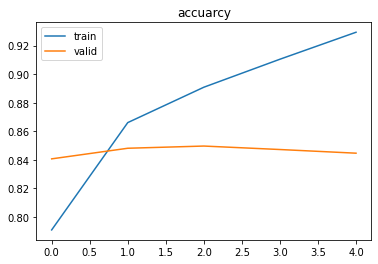

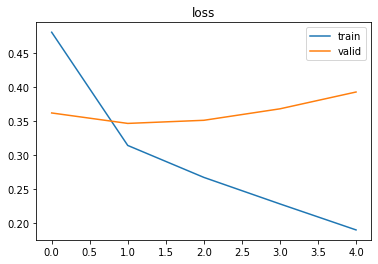

1537/1537 [==============================] - 2s 2ms/step - loss: 0.3901 - accuracy: 0.8458
[0.39008429646492004, 0.8457595109939575]


In [130]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(voca_size, word_vector_dim))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(25, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, batch_size=512, validation_data=(X_valid, y_valid))

accuarcy = history.history["accuracy"]
loss = history.history["loss"]
valid_acc = history.history["val_accuracy"]
valid_loss = history.history["val_loss"]

plt.plot(accuarcy, label="train")
plt.plot(valid_acc, label="valid")
plt.title("accuarcy")
plt.legend()
plt.show()

plt.plot(loss, label="train")
plt.plot(valid_loss, label="valid")
plt.title("loss")
plt.legend()
plt.show()

print(model.evaluate(X_test, y_test))

In [131]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

index_to_word = {index:word for index, word in enumerate(vocab)}

word2vec_file_path1 = "/aiffel/aiffel/sentiment_classification/data/word2vec1.txt"

f = open(word2vec_file_path1, "w")
f.write('{} {}\n'.format(voca_size-3, word_vector_dim))

vectors = model.layers[0].get_weights()[0]
for i in range(3, voca_size):
    f.write("{} {}\n".format(index_to_word[i], " ".join(map(str, list(vectors[i, :])))))
f.close()

In [132]:
word2vec_file_path1 = "/aiffel/aiffel/sentiment_classification/data/word2vec1.txt"
word2vec_file_path2 = "/aiffel/aiffel/sentiment_classification/data/word2vec_ko.model"

my_word2vec = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path1, binary=False)
word2vec = Word2VecKeyedVectors.load(word2vec_file_path2)
print("my : ")
my_word2vec.similar_by_word("짱짱")
print("yours : ")
word2vec.wv.similar_by_word("짜증")

my : 
yours : 


[('웃기', 0.6960893869400024),
 ('슬프', 0.6951370239257812),
 ('들통', 0.6827743649482727),
 ('싫증', 0.6693235635757446),
 ('아무렇', 0.6588257551193237),
 ('정말', 0.6521912813186646),
 ('거짓말', 0.6506513357162476),
 ('더럽', 0.6503365635871887),
 ('뭔가', 0.6475220322608948),
 ('부끄러움', 0.6413039565086365)]

Epoch 1/5
229/229 [==============================] - 10s 24ms/step - loss: 0.4694 - accuracy: 0.7748 - val_loss: 0.3639 - val_accuracy: 0.8437
Epoch 2/5
229/229 [==============================] - 4s 18ms/step - loss: 0.3257 - accuracy: 0.8637 - val_loss: 0.3384 - val_accuracy: 0.8527
Epoch 3/5
229/229 [==============================] - 4s 18ms/step - loss: 0.2834 - accuracy: 0.8836 - val_loss: 0.3276 - val_accuracy: 0.8580
Epoch 4/5
229/229 [==============================] - 4s 18ms/step - loss: 0.2499 - accuracy: 0.8992 - val_loss: 0.3355 - val_accuracy: 0.8587
Epoch 5/5
229/229 [==============================] - 4s 18ms/step - loss: 0.2191 - accuracy: 0.9141 - val_loss: 0.3707 - val_accuracy: 0.8513


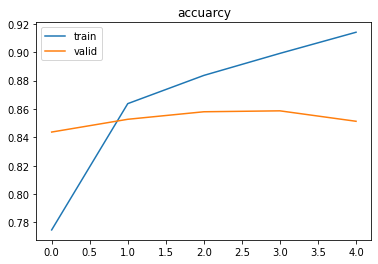

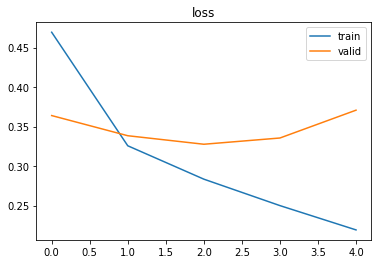

1537/1537 [==============================] - 8s 5ms/step - loss: 0.3732 - accuracy: 0.8508
[0.3732238709926605, 0.8507638573646545]


In [133]:
from tensorflow.keras.initializers import Constant

voca_size = 10000
word_vector_dim = 100

embedding_matrix = np.random.rand(voca_size, word_vector_dim)

for i in range(4, voca_size):
    if index_to_word[i] in word2vec.wv.key_to_index:
        embedding_matrix[i] = word2vec.wv.vectors[word2vec.wv.key_to_index[index_to_word[i]]]
model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(voca_size, word_vector_dim))
model.add(tf.keras.layers.LSTM(100, return_sequences=True))
model.add(tf.keras.layers.LSTM(50, return_sequences=True))
model.add(tf.keras.layers.LSTM(25, return_sequences=True))
model.add(tf.keras.layers.LSTM(10))
model.add(tf.keras.layers.Dense(5, activation="relu"))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, batch_size=512, validation_data=(X_valid, y_valid))

accuarcy = history.history["accuracy"]
loss = history.history["loss"]
valid_acc = history.history["val_accuracy"]
valid_loss = history.history["val_loss"]

plt.plot(accuarcy, label="train")
plt.plot(valid_acc, label="valid")
plt.title("accuarcy")
plt.legend()
plt.show()

plt.plot(loss, label="train")
plt.plot(valid_loss, label="valid")
plt.title("loss")
plt.legend()
plt.show()

print(model.evaluate(X_test, y_test))